In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/russianinappropriatemessages/Inappapropriate_messages.csv


In [2]:
# pip install transformers sentencepiece
import torch
from transformers import AutoTokenizer, AutoModel
import seaborn as sns

from datasets import load_dataset
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from tqdm.notebook import tqdm

In [3]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")
# model.cuda()  # uncomment it if you have a GPU

In [4]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(29564, 312, padding_idx=0)
    (position_embeddings): Embedding(512, 312)
    (token_type_embeddings): Embedding(2, 312)
    (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-2): 3 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=312, out_features=312, bias=True)
            (key): Linear(in_features=312, out_features=312, bias=True)
            (value): Linear(in_features=312, out_features=312, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=312, out_features=312, bias=True)
            (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
    

In [5]:
text = ["LLM - смысл моей жизни", "Не знаю, как мне жить без LLM"]
t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
with torch.no_grad():
    inputs = {k: v.to(model.device) for k, v in t.items()}
    model_output = model(**inputs)

In [6]:
print(len(t[0].tokens), t[0].tokens)
print(len(t[1].tokens), t[1].tokens)

13 ['[CLS]', 'LL', '##M', '-', 'см', '##ыс', '##л', 'м', '##ое', '##й', 'жизни', '[SEP]', '[PAD]']
13 ['[CLS]', 'Не', 'з', '##на', '##ю', ',', 'как', 'мне', 'жить', 'без', 'LL', '##M', '[SEP]']


## 1 - Padding

Обратите внимание, что в конце каждого из двух предложений добавляется спецтокен [SEP] (даже без упоминания задачи NSP), а также в первом тексте добавлен токен [PAD]. Почему добавлен токен [PAD]?

In [7]:
t.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [8]:
t.input_ids

tensor([[    2,  9416,  1521,    17,  4159, 11654,   869,   324,  4427,   775,
          4482,     3,     0],
        [    2,  6226,   319,   794,   920,    16,  1150, 20284, 27162,  2399,
          9416,  1521,     3]])

In [9]:
t.token_type_ids

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Attention-маска определяет, какие токены будут использоваться для подсчета self-attention в каждом энкодер-блоке. В случае BERT мы игнорируем все [PAD]-токены в таких подсчетах, тк padding не несет никакой семантики и кол-во таких токенов зависит от размера контекста либо наиболее длинной последовательности в батче

In [10]:
t.attention_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

## 2 - Выход модели BERT

In [11]:
model_output.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

Определите, какая размерность будет на выходе из последнего слоя данной BERT-модели при данном входе:

In [ ]:
print('Shape выхода одного текста (первая размерность отвечает за batch_size, то есть кол-во текстов):\n\n\t', model_output.last_hidden_state.shape)

In [ ]:
embeddings = model_output.last_hidden_state[:, 0, :]
embeddings.shape

Как правило, нейронные сети гораздо эффективнее обучаются, если подавать им на вход нормализованные данные. Поэтому BERT-эмбеддинги тоже часто нормализуют.

Важно: нормализуем по размерности dim=1, которая соответствует компонентам одного эмбеддинга (то есть при подсчете mean и std используется эмбеддинг только одного текста).

In [ ]:
embeddings = torch.nn.functional.normalize(embeddings)
embeddings.shape

Далее в качестве эмбеддинга всего текста можем взять эмбеддинг [CLS]-токена

In [ ]:
embeddings = embeddings[0].cpu().numpy()
embeddings.shape

## 3 - BERT для поиска похожих

Напишем функцию, с помощью которой будем считать эмбеддинги для нескольких текстов одновременно - батчами (на гпу это значительно ускоорит подсчет эмбеддингов, можете проверить)

В функции предусмотрено два режима mode: 
* 'cls' - в качестве текстового эмбеддинга используем эмбеддинг [CLS] токена с последнего слоя
* 'mean' - в качестве текстового эмбеддинга используем усредненный эмбеддинг всех значимых токенов с последнего слоя. Незначимые токены - токены [PAD], которые мы не используем в усреденении. Обратите внимание, как мы используем маску mask для выделения из всех эмбеддингов эмбеддинги только значимых токенов.

In [16]:
def embed_bert_cls(text_batch, model, tokenizer, mode):
    t = tokenizer(text_batch, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
        
        embeddings = None
        if mode == 'mean':
            embeddings = []
            for embs, mask in zip(model_output.last_hidden_state, t.attention_mask):
                embeddings.append( embs[mask.type(torch.bool)].mean(0).cpu() )
            embeddings = torch.stack(embeddings)
        elif mode == 'cls':
            embeddings = model_output.last_hidden_state[:, 0, :].cpu()
        else:
            raise ValueError('Unknown mode')
    
    return torch.nn.functional.normalize(embeddings, dim=1)

Скачаем новостные статьи как в дз 1

In [17]:
def get_dataset(train_size: int,
                test_size: int,
                ds_name_1: str = 'IlyaGusev/gazeta',
               ): 
    
    train_dataset = load_dataset(ds_name_1, split='train')
    test_dataset = load_dataset(ds_name_1, split='test')

    train_df = pd.DataFrame(train_dataset).iloc[:train_size]
    print(train_df.shape)

    test_df = pd.DataFrame(test_dataset)[:test_size]
    print(test_df.shape)

    train_texts = (train_df['title'] + '\n' + train_df['text']).tolist()
    test_texts = (test_df['title'] + '\n' + test_df['text']).tolist()
    
    return train_texts, test_texts

In [18]:
train_texts, test_texts = get_dataset(10_000, 1_000)

(10000, 5)
(1000, 5)


Оставим из новостей только заголовки для удобства их чтения (вам, ведь модель BERT вполне справится с чтением и всего текста) :)

In [19]:
test_headlines = list(map(lambda w: w.split('\n')[0], test_texts))
test_headlines[:15]

['В Германии объяснили упоминание имени Путина на протестах в Берлине ',
 'Делегации Израиля и США прибыли в ОАЭ для обсуждения соглашения о сотрудничестве ',
 'Оппозиция Белоруссии объявила о создании новой партии «Вместе» ',
 'Россия считает крайне опасными действия США на учениях в Эстонии ',
 'В России вступил в силу закон о внесудебном банкротстве частных лиц ',
 '100 лет назад Красная армия под командованием Фрунзе взяла Бухару ',
 'В ООН ответили Поклонской по вопросу о водной блокаде Крыма Украиной ',
 'Умер детский писатель Владислав Крапивин ',
 'Минобороны РФ опровергло заявление НАТО о нарушении датских границ ',
 'Трамп предрек революцию в Америке в случае победы Байдена ',
 'Врачи предупредили об опасности ожирения при COVID-19 ',
 'Помпео указал на рост активности военных РФ в различных регионах мира ',
 'CNBC: решение о продаже TikTok примут в ближайшие сутки ',
 'Лавров призвал Запад не навязывать Белоруссии «посреднические услуги» ',
 'Депардье вспомнил, как Путин при

Как мы видим, новости во многом про политику, реже встречаются другие темы, например, про ковид:

In [20]:
test_headlines[10]

'Врачи предупредили об опасности ожирения при COVID-19 '

Подгрузим небольшую BERT-модель, чтобы быстро предподсчитать эмбеддинги. Далее мы будем использовать BERT как экстрактор семантических признаков из текста, т.е. с помощью BERT мы переведем текст в вектор в некотором пространстве, в котором в идеале семантически похожие тексты должны лежать близко друг к другу, а непохожие - далеко.

rubert-tiny - небольшая дистиллированая BERT-модель (вспоминаем DistillBERT, который обсуждали на лекции), которая обучалась преимущественно на русскоязычном корпусе (то есть домен - тексты на русском языке). Подробности модели можете посмотреть на hugginface в карточке модели:

https://huggingface.co/cointegrated/rubert-tiny

In [21]:
MODEL_MAX_LENGTH = 512 # длина контекста, можно взять из конфига модели-учителя: https://huggingface.co/google-bert/bert-base-multilingual-cased/blob/main/config.json

rubert_tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
rubert_model = AutoModel.from_pretrained("cointegrated/rubert-tiny")

# rubert_tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-large", model_max_length=MODEL_MAX_LENGTH)
# rubert_model = AutoModel.from_pretrained("ai-forever/ruBert-large")

rubert_model.cuda() # иначе слишком долго считать

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(29564, 312, padding_idx=0)
    (position_embeddings): Embedding(512, 312)
    (token_type_embeddings): Embedding(2, 312)
    (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-2): 3 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=312, out_features=312, bias=True)
            (key): Linear(in_features=312, out_features=312, bias=True)
            (value): Linear(in_features=312, out_features=312, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=312, out_features=312, bias=True)
            (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
    

In [22]:
TEXT_BATCH_SIZE = 64 # по 64 текста одновременно прогоняем через BERT

def precalc_embeddings(texts, model, tokenizer, mode):
    embeddings = []
    for start_num in tqdm(range(0, len(texts), TEXT_BATCH_SIZE)):
        text_batch = texts[start_num: start_num + TEXT_BATCH_SIZE]
        emb_output = embed_bert_cls(text_batch, model, tokenizer, mode = mode)
        embeddings.append(emb_output)

    embeddings = np.concatenate(embeddings)
    return embeddings

In [23]:
embeddings = precalc_embeddings(test_texts, rubert_model, rubert_tokenizer, mode='cls')

  0%|          | 0/16 [00:00<?, ?it/s]

In [24]:
pos = 10
test_headlines[pos]

'Врачи предупредили об опасности ожирения при COVID-19 '

In [25]:
sims = cosine_similarity(embeddings[pos][None, :], embeddings) #embeddings[pos + 1:])
sims.shape

(1, 1000)

In [26]:
most_similar = sorted( list(zip(sims[0], np.arange(sims.shape[1]))) , reverse=True)

In [27]:
most_similar[0] # естественно, самый близкий текст к исходному - это исходный текст, поэтому его игнорируем

(1.0000002, 10)

In [ ]:
print('Исходный текст:', test_headlines[pos], '\n')

print('Самые похожие тексты:\n')
for score, index in most_similar[1:5]:
    print(f"Sim={score} \t\t {test_headlines[index]}")
    
print('\n', '=' * 30, '\n')

print('Самые непохожие тексты:\n')
for score, index in most_similar[-5:]:
    print(f"Sim={score} \t\t {test_headlines[index]}")

Определите текст, наиболее похожий на исходный текст, с помощью кода ниже. В качестве ответа приведете текст, заключенный внутри знаков знаки <>.

In [ ]:
print( f'Ответ: <{test_headlines[most_similar[1][1]].strip()}>' )

При том, что в тексте большая часть заголовков про политику, с помощью BERT-эмбеддингов мы без труда нашли несколько текстов, похожих на исходный - по тематике ковида

Аналогично можно усреднять выходные эмбеддинги (не считая pad-токена). В данном случае, результат будет похожий (но заметьте, что при этом топ-5 отличается).

Качество при разных способах получения эмбеддингов в данном случае особо не меняется из-за того, что [CLS] токен в исходной модели (учителе) обучался на задачу NSP. Если бы мы имели дело с RoBERT-a подобной моделью, то эмбеддинг [CLS]-токена из последнего слоя извлекал бы "более рандомные" признаки - ведь он ни на что не обучался во время претрейна, поэтому этот эмбеддинг агрегирует в себе эмбеддинги всех токенов из предпоследнего слоя (вспомните как работает self-attention)

In [ ]:
embeddings = precalc_embeddings(test_texts, rubert_model, rubert_tokenizer, mode='mean')

pos = 10
sims = cosine_similarity(embeddings[pos][None, :], embeddings) #embeddings[pos + 1:])
most_similar = sorted( list(zip(sims[0], np.arange(sims.shape[1]))) , reverse=True)

print('Исходный текст:', test_headlines[pos], '\n')

print('Самые похожие тексты:\n')
for score, index in most_similar[1:5]:
    print(f"Sim={score} \t\t {test_headlines[index]}")
    
print('\n', '=' * 30, '\n')

print('Самые непохожие тексты:\n')
for score, index in most_similar[-5:]:
    print(f"Sim={score} \t\t {test_headlines[index]}")

## 4 - важность домена, на котором обучалась претрейн-модель

In [31]:
del model
del rubert_model

In [32]:
MODEL_MAX_LENGTH = 512 # длина контекста, можно взять из конфига модели-учителя: https://huggingface.co/google-bert/bert-base-multilingual-cased/blob/main/config.json

en_roberta_tokenizer = AutoTokenizer.from_pretrained('FacebookAI/roberta-base')
en_roberta_model = AutoModel.from_pretrained('FacebookAI/roberta-base')

en_roberta_model.cuda() # иначе слишком долго считать

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [ ]:
embeddings = precalc_embeddings(test_texts, en_roberta_model, en_roberta_tokenizer, mode='cls')

pos = 10
sims = cosine_similarity(embeddings[pos][None, :], embeddings)
most_similar = sorted( list(zip(sims[0], np.arange(sims.shape[1]))) , reverse=True)

print('Исходный текст:', test_headlines[pos], '\n')

print('Самые похожие тексты:\n')
for score, index in most_similar[1:5]:
    print(f"Sim={score} \t\t {test_headlines[index]}")
    
print('\n', '=' * 30, '\n')

print('Самые непохожие тексты:\n')
for score, index in most_similar[-5:]:
    print(f"Sim={score} \t\t {test_headlines[index]}")

In [ ]:
embeddings = precalc_embeddings(test_texts, en_roberta_model, en_roberta_tokenizer, mode='mean')

pos = 10
sims = cosine_similarity(embeddings[pos][None, :], embeddings)
most_similar = sorted( list(zip(sims[0], np.arange(sims.shape[1]))) , reverse=True)

print('Исходный текст:', test_headlines[pos], '\n')

print('Самые похожие тексты:\n')
for score, index in most_similar[1:5]:
    print(f"Sim={score} \t\t {test_headlines[index]}")
    
print('\n', '=' * 30, '\n')

print('Самые непохожие тексты:\n')
for score, index in most_similar[-5:]:
    print(f"Sim={score} \t\t {test_headlines[index]}")

Определите текст, наиболее похожий на исходный текст, с помощью кода ниже (используйте режим "mean" при подсчете эмбеддингов). В качестве ответа приведете текст, заключенный внутри знаков знаки <>.

In [ ]:
print( f'Ответ: <{test_headlines[most_similar[1][1]].strip()}>' )

Как мы видим, тексты не то чтобы похожи, хотя датасет тот же самый. Это связано с тем, что RoBERTa, загруженная выше, обучалась на другом домене (преимущественно на англоязычных текстах), из-за чего на домене русскоязычных текстов эмбеддинги получаются так себе.

Попробуем перевести самые похожие тексты для rubert-tiny и для roberta с русского на английский, и попробуем теперь посмотреть, какие тексты окажутся похожими

In [36]:
translated_news = [
"The EU has agreed to expand the list of sanctions against the Russian Federation for the Crimean Bridge",
"Roscosmos has agreed with a private firm to build a competitor to Musk's ship",
"The Ministry of Defense has revealed details of joint exercises between Russia and Belarus",
"Pamfilova announced the full readiness of the electoral system for the elections",
"The programmer launched Doom and Skyrim on a pregnancy test",

"Doctors warned of the dangers of obesity in COVID-19",
"A factor significantly reducing mortality from COVID-19 has been named",
"Scientists: glasses wearers suffer from COVID-19 five times less often",
"Scientists told about the danger of coronavirus for pregnant women",
"A new dangerous consequence of COVID-19 has been discovered"
]

test_headlines = translated_news

embeddings = precalc_embeddings(test_headlines, en_roberta_model, en_roberta_tokenizer, mode='mean')

pos = 5
sims = cosine_similarity(embeddings[pos][None, :], embeddings) #embeddings[pos + 1:])
most_similar = sorted( list(zip(sims[0], np.arange(sims.shape[1]))) , reverse=True)

print('Исходный текст:', test_headlines[pos], '\n')

print('Самые похожие тексты:\n')
for score, index in most_similar[1:5]:
    print(f"Sim={score} \t\t {test_headlines[index]}")
    
print('\n', '=' * 30, '\n')

print('Самые непохожие тексты:\n')
for score, index in most_similar[-5:]:
    print(f"Sim={score} \t\t {test_headlines[index]}")

  0%|          | 0/1 [00:00<?, ?it/s]

Исходный текст: Doctors warned of the dangers of obesity in COVID-19 

Самые похожие тексты:

Sim=0.9816614985466003 		 Scientists told about the danger of coronavirus for pregnant women
Sim=0.9793349504470825 		 A new dangerous consequence of COVID-19 has been discovered
Sim=0.977390706539154 		 A factor significantly reducing mortality from COVID-19 has been named
Sim=0.9762434959411621 		 Scientists: glasses wearers suffer from COVID-19 five times less often


Самые непохожие тексты:

Sim=0.9704751372337341 		 Pamfilova announced the full readiness of the electoral system for the elections
Sim=0.9676637053489685 		 The programmer launched Doom and Skyrim on a pregnancy test
Sim=0.9599279165267944 		 The Ministry of Defense has revealed details of joint exercises between Russia and Belarus
Sim=0.959205687046051 		 The EU has agreed to expand the list of sanctions against the Russian Federation for the Crimean Bridge
Sim=0.956506609916687 		 Roscosmos has agreed with a private firm to

Теперь самые похожие тексты действительно похожи на исходный - потому что рабоатет в том же домене, в котором обучаласт претрейн-модель

## 5 - finetuning

В качестве датасета возьмем датасет неуместных запросов на русском языке (120к текстов). 1 - запрос неуместный, 0 - уместный.

Датасет: https://www.kaggle.com/datasets/nigula/russianinappropriatemessages

Можно добавить этот датасет в Kaggle через "add input" в правой панели, либо просто скачать и поменять путь к нему в коде ниже.

Будем решать важную задачу фильтрации запросов для генеративных моделей - фильтрация некорректных запросов. Отвечать на такие запросы с помощью генеративной модели опасно - можно навредить пользователю, поэтому задача - отбивать подобные запросы с помощью классификатора.

Ниже описана подготовка данных, а также инициализация токенизатора и BERT-модели - всё как на семинаре.

In [37]:
import pandas as pd
import numpy as np
import random
import torch
import transformers
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import load_metric, Dataset
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns 
from sklearn.metrics import f1_score

2024-03-05 20:11:33.334901: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 20:11:33.334961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 20:11:33.336506: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/tmp/ipykernel_146707/1230382672.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['inappropriate'])
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='inappropriate', ylabel='Density'>

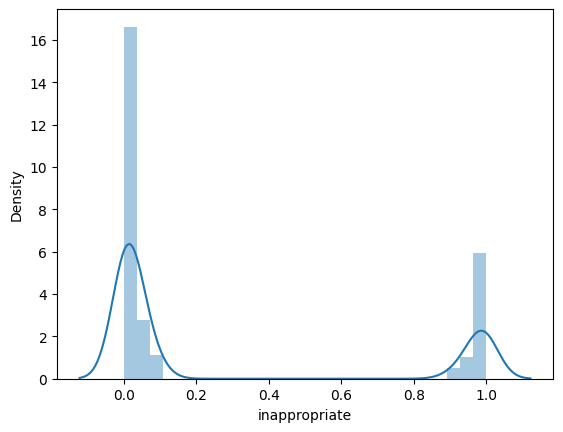

In [38]:
data_path = '/kaggle/input/russianinappropriatemessages/Inappapropriate_messages.csv'

df = pd.read_csv(data_path)

sns.distplot(df['inappropriate'])

In [39]:
df = pd.read_csv(data_path)
df.rename({'inappropriate': 'target'}, axis=1, inplace=True)
df['target'] = (df['target'] >= 0.5).astype(int)

TEST_SIZE = 0.2

train_df, test_df = train_test_split(df, test_size=TEST_SIZE)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

train_text = train_df['text'].astype(str)
train_labels = train_df['target']

test_text = test_df['text'].astype(str)
test_labels = test_df['target']

In [40]:
df['target'].value_counts()

target
0    91448
1    33149
Name: count, dtype: int64

In [41]:
len(train_text), len(train_labels), len(test_text), len(test_labels)

(99677, 99677, 24920, 24920)

In [42]:
tokenizer = BertTokenizer.from_pretrained('cointegrated/rubert-tiny2')


seq_len_train = [len(str(i).split()) for i in train_df['text']]
seq_len_test = [len(str(i).split()) for i in test_df['text']]
max_seq_len = min(512, max(max(seq_len_test), max(seq_len_train)))
max_seq_len


tokens_train = tokenizer.batch_encode_plus(
    train_text.values,
    max_length = max_seq_len,
    padding = 'max_length',
    truncation = True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.values,
    max_length = max_seq_len,
    padding = 'max_length',
    truncation = True
)


class Data(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item
    def __len__(self):
        return len(self.labels)
    
train_dataset = Data(tokens_train, train_labels)
test_dataset = Data(tokens_test, test_labels)

print(len(train_dataset), len(test_dataset))

99677 24920


In [43]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds)
    return {'F1': f1}

In [44]:
# для воспроизводимости результатов
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False

Берем предобученную русскоязычную модель и с помощью hugginface запускаем дообучение под нашу целевую задачу. Обучаем 1 эпоху, чтобы убедиться что всё работает. В Kaggle одна эпоха проходит примерно за 20 минут. Hugginface в процессе обучения рисует после каждой эпохи табличку, в которой показываем качество модели на данном этапе. В данном случае в качестве метрики мы используем f1-score в задаче бинарной классификации, поставленной выше.

In [10]:
model = BertForSequenceClassification.from_pretrained('cointegrated/rubert-tiny2', num_labels=2).to("cuda")

training_args = TrainingArguments(
    output_dir = './results', #Выходной каталог
    num_train_epochs = 1, # 3, #Кол-во эпох для обучения
    per_device_train_batch_size = 8, #Размер батча для каждого устройства во время обучения
    per_device_eval_batch_size = 8, #Размер батча для каждого устройства во время валидации
    weight_decay = 0.01, # регуляризация
    logging_dir = './logs', # Каталог для хранения логов
    report_to = 'tensorboard',
    load_best_model_at_end = True, # Загружать ли лучшую модель после обучения
    learning_rate = 1e-5, # Скорость обучения
    evaluation_strategy ='epoch', #Валидация после каждой эпохи (можно сделать после конкретного кол-ва шагов)
    logging_strategy = 'epoch', #Логирование после каждой эпохи
    save_strategy = 'epoch', #Сохранение после каждой эпохи
    save_total_limit = 1,
    seed=42)


seed_all(42)

trainer = Trainer(model=model,
                  tokenizer = tokenizer,
                  args = training_args,
                  train_dataset = train_dataset,
                  eval_dataset = train_dataset,
                  compute_metrics = compute_metrics)


trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1
1,0.436800,0.387233,0.654412


Checkpoint destination directory ./results/checkpoint-6230 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=6230, training_loss=0.4368267910438403, metrics={'train_runtime': 1040.7025, 'train_samples_per_second': 95.779, 'train_steps_per_second': 5.986, 'total_flos': 735038828746752.0, 'train_loss': 0.4368267910438403, 'epoch': 1.0})

In [11]:
del model # освободим память и переинициализируем модель, чтобы точно не перепутать

Дообучите модель с параметрами ниже. Из нового - обучаем 3 эпохи вместо одной и с большим batch_size. 

Во время обучения трейнер hugginface отрисовывает таблицу с метриками прсле каждой эпохи. В качестве ответа укажите значение метрики f1 после третьей эпохи, округлив его до третьего знака после запятой с помощью функции round(..., 3). 

Погрешность ответа в проверяющей системе учитывает возможную случайность, возникающую при обучении. Если вы всё сделали правильно, то ответ, который вы введете, будет засчитан системой как верный.

In [ ]:
model = BertForSequenceClassification.from_pretrained('cointegrated/rubert-tiny2', num_labels=2).to("cuda")

training_args = TrainingArguments(
    num_train_epochs = 3, # 3, #Кол-во эпох для обучения
    per_device_train_batch_size = 16, #Размер батча для каждого устройства во время обучения
    per_device_eval_batch_size = 16, #Размер батча для каждого устройства во время валидации
    seed=42
    ...
) # заполните остальные параметры как в примере выше


seed_all(42)

trainer = Trainer( ... ) # заполните как в примере выше


trainer.train()

## Если вам было мало моделей

Тут в посте сделал короткую шпаргалку с ключевыми идеями других трансформерных моделей и их нововведениями относительно оригинального BERT-а. Может быть полезно, чтобы подчерпнуть идеи для собственных моделей либо вспомнить в общих чертах материал перед собеседованиями :) 

https://t.me/skeptical_research/27

## Не забывайте ставить звезды на гитхабе и оставлять обратную связь по лекции и дз!